In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [4]:
from matplotlib import colormaps as cm
from matplotlib.patches import Patch

In [6]:
metadata = pd.read_csv("metadata.csv",index_col=0).dropna()

In [8]:
counts = pd.read_csv("SCT_normalized.csv",index_col=0).T

In [10]:
counts = counts.loc[metadata.index]

In [12]:
regress = metadata.join(counts).drop("Cell Type",axis=1)

In [14]:
regress_mean = regress.groupby("Subtype").mean()

In [16]:
features = ["Trough","Frequency","Peak","Threshold","Ratio","Vrest"]
genes = counts.columns

In [18]:
from tqdm import tqdm

In [20]:
res = {}
for feature in features:
    res_feature = {}
    y = regress_mean[feature]
    for gene in tqdm(genes):
        x = regress_mean[gene]
        if sum(x) == 0:
            continue
        lr = stats.linregress(x,y)
        res_feature[gene] = (lr.pvalue,lr.rvalue)
    res_feature_df = pd.DataFrame.from_dict(res_feature)
    res_feature_df.index = ["p","R"]
    padjust = stats.false_discovery_control(res_feature_df.loc["p",:])
    res_feature_df.loc["padj"] = padjust

    res[feature] = res_feature_df

100%|██████████████████████████████████████████████████████████████████████████| 37842/37842 [00:05<00:00, 7116.04it/s]


In [86]:
feature = "Vrest"
df = res[feature]
gene_list = df.T[(df.T.padj<0.01) & (abs(df.T.R)>0.5)]

In [24]:
mapping = metadata[["Cell Type","Subtype"]].drop_duplicates().set_index("Subtype")
mapping = mapping[~mapping.index.duplicated()]
regress_mean["Type"] = mapping.loc[regress_mean.index]

In [47]:
df.T.to_csv("Trough_lr.csv",index=True)

In [88]:
gene_list.to_csv("Vrest.csv",index=True)

In [26]:
cell_types = pd.unique(mapping["Cell Type"])

cmap = plt.colormaps['viridis']  # or 'Set2', 'viridis', etc.

# 3. Get 5 evenly spaced colors
colors = [cmap(i) for i in np.linspace(0, 1, len(cell_types))]

# 4. Map cell types to colors
cell_type_to_color = dict(zip(cell_types, colors))

In [32]:
def plot(df,stat,gene,cell_type_to_color,title=None):
    plt.figure(dpi=300)
    if title:
        plt.plot(title)
    else:
        plt.title(gene)
    y = df[feature]
    x = df[gene]
    plt.scatter(x,y,c=list(map(lambda x:cell_type_to_color[x],regress_mean.Type)))
    model = stats.linregress(x,y)
    plt.plot(x,model.slope*x+model.intercept,color="red")
    plt.xlabel("Gene Expression")
    plt.ylabel(feature)
    ax = plt.gca()
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    plt.annotate(text=f"Adjusted p-value: {stat[gene].padj:.2e} \nR-value: {stat[gene].R:.2f}",xy=(min(x),max(y)),
                va="top",ha="left")

    legend_elements = [Patch(facecolor=cell_type_to_color[ct], label=ct) for ct in cell_types]
    plt.legend(handles=legend_elements, title="Cell Type",bbox_to_anchor=(1.05,0.7))
    plt.show()

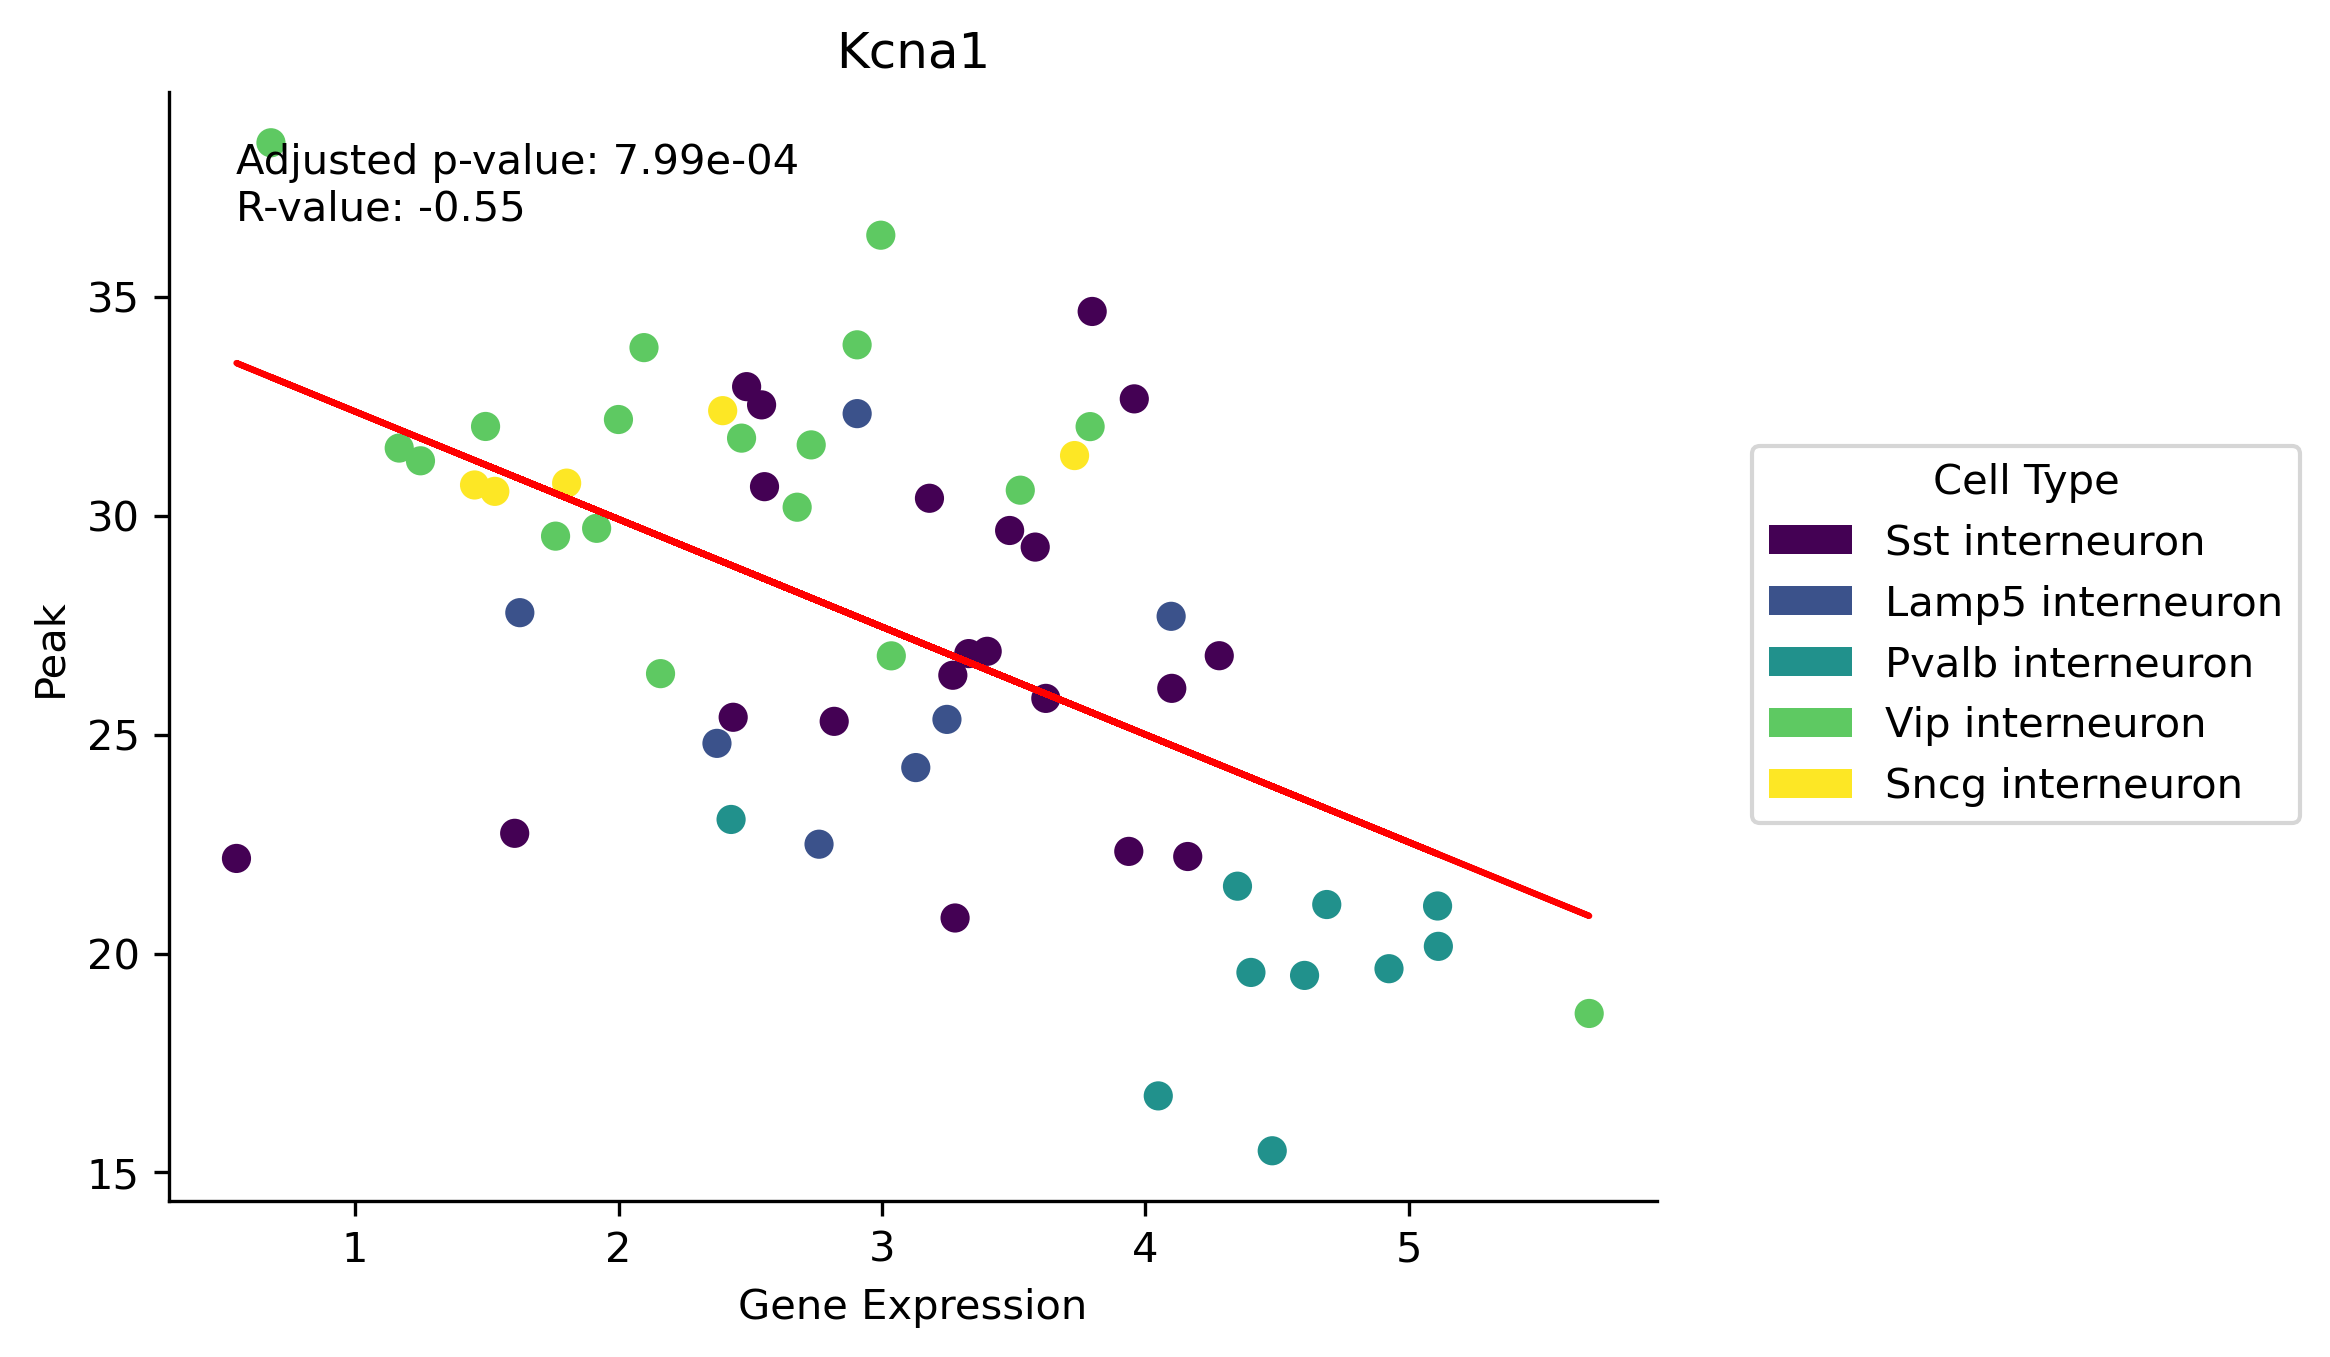

In [36]:
plot(regress_mean,df,"Kcna1",cell_type_to_color)

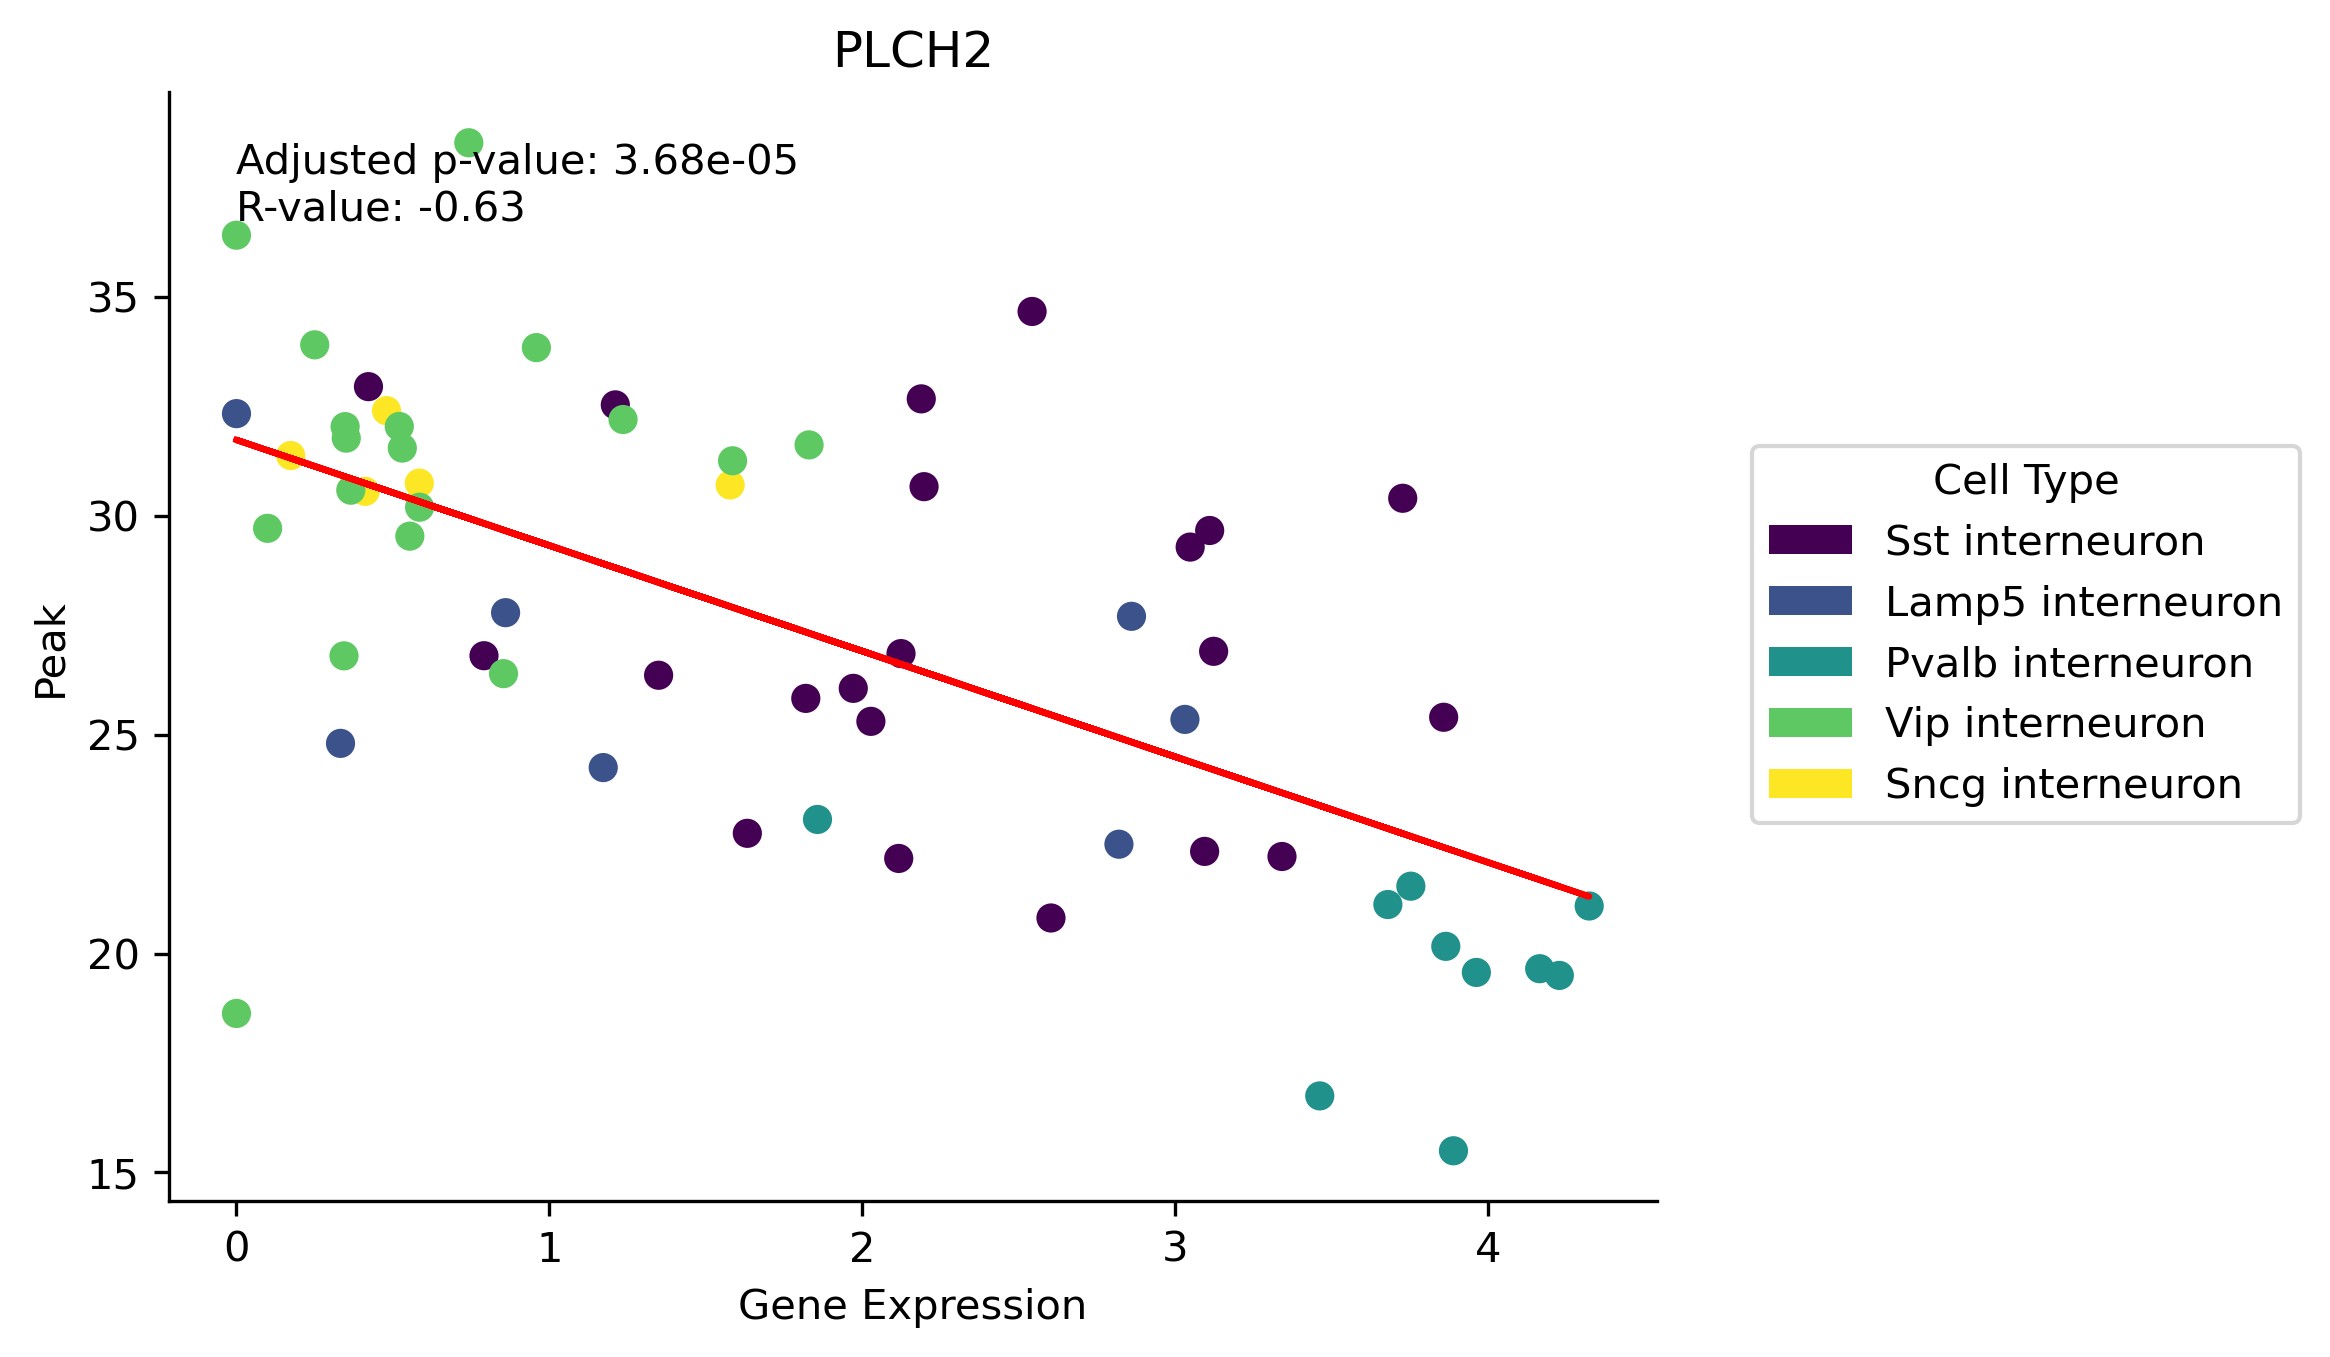

In [187]:
plot(regress_mean,df,"Plch2",cell_type_to_color)